In [1]:
from typing import Dict, Tuple

import numpy as np
import pandas as pd
from postprocess.lps_plots import sel_evaluation_domain
from products.plot_settings import MF_SYNOPSIS_VAR_NAME, NASA_L3_JPSS1_VAR_NAME, NASA_L3_SNPP_VAR_NAME,MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME
from reductions.statistics_base import EvaluationVsHighResBase
from winter_year import WinterYear
import xarray as xr
from xarray.groupers import BinGrouper

wy = WinterYear(2023, 2024)
analysis_folder = (
    "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_6_lps/analyses/"
)
analysis_type = "confusion_table"

analyses_dict_confusion = {
    MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_meteofrance_no_forest_red_band_screen_vs_s2_theia.nc",
        decode_cf=True,
    ),
    NASA_L3_SNPP_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_snpp_vs_s2_theia.nc", decode_cf=True
    ),
    NASA_L3_JPSS1_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_jpss1_vs_s2_theia.nc",
        decode_cf=True,
    ),
}

analysis_type = "uncertainty"

analyses_dict_uncertainty = {
    MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_meteofrance_no_forest_red_band_screen_vs_s2_theia.nc",
        decode_cf=True,
    ),
    NASA_L3_SNPP_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_snpp_vs_s2_theia.nc", decode_cf=True
    ),
    NASA_L3_JPSS1_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_jpss1_vs_s2_theia.nc",
        decode_cf=True,
    ),
}

def sel_evaluation_domain(analyses_dict: Dict[str, xr.Dataset]) -> Tuple[Dict[str, xr.Dataset], str]:
    selection_dict = {
        k: v.sel(
            time=slice("2023-12", "2024-06"),
            altitude_bins=slice(900, None),
            ref_bins=slice(0, 101),
            slope_bins=slice(None, 60),
        )
        for k, v in analyses_dict.items()
    }

    selection_dict = {
        k: v.assign_coords(
            {
                "aspect_bins": pd.CategoricalIndex(
                    data=EvaluationVsHighResBase.aspect_bins().labels,
                    categories=EvaluationVsHighResBase.aspect_bins().labels,
                    ordered=True,
                ),
                "forest_mask_bins": ["Open", "Forest"],
                "slope_bins": np.array(["[0-10]", "[11-30]", ">30"], dtype=str),
            }
        )
        for k, v in selection_dict.items()
    }

    selection_dict = {
        k: v.rename(
            {"aspect_bins": "Aspect", "forest_mask_bins": "Landcover", "slope_bins": "Slope [°]"}
        )
        for k, v in selection_dict.items()
    }

    return selection_dict



metrics_dict_conf = sel_evaluation_domain(analyses_dict=analyses_dict_confusion)
metrics_dict_conf = {k:v.groupby(ref_bins=BinGrouper(bins=[-1,0,99,100], labels=["0", "[1-99]", "100"])).sum().rename({"ref_bins_bins": "Ref FSC [%]"}) for k,v in metrics_dict_conf.items()}
metrics_dict_unc = sel_evaluation_domain(analyses_dict=analyses_dict_uncertainty)
metrics_dict_unc = {k:v.sum(dim=( 'time')).assign_coords(ref_bins=["0", "[1-25]", "[26-50]","[51-75]", "[75-99]", "100"]).rename({"ref_bins": "Ref FSC [%]"}) for k,v in metrics_dict_unc.items()}

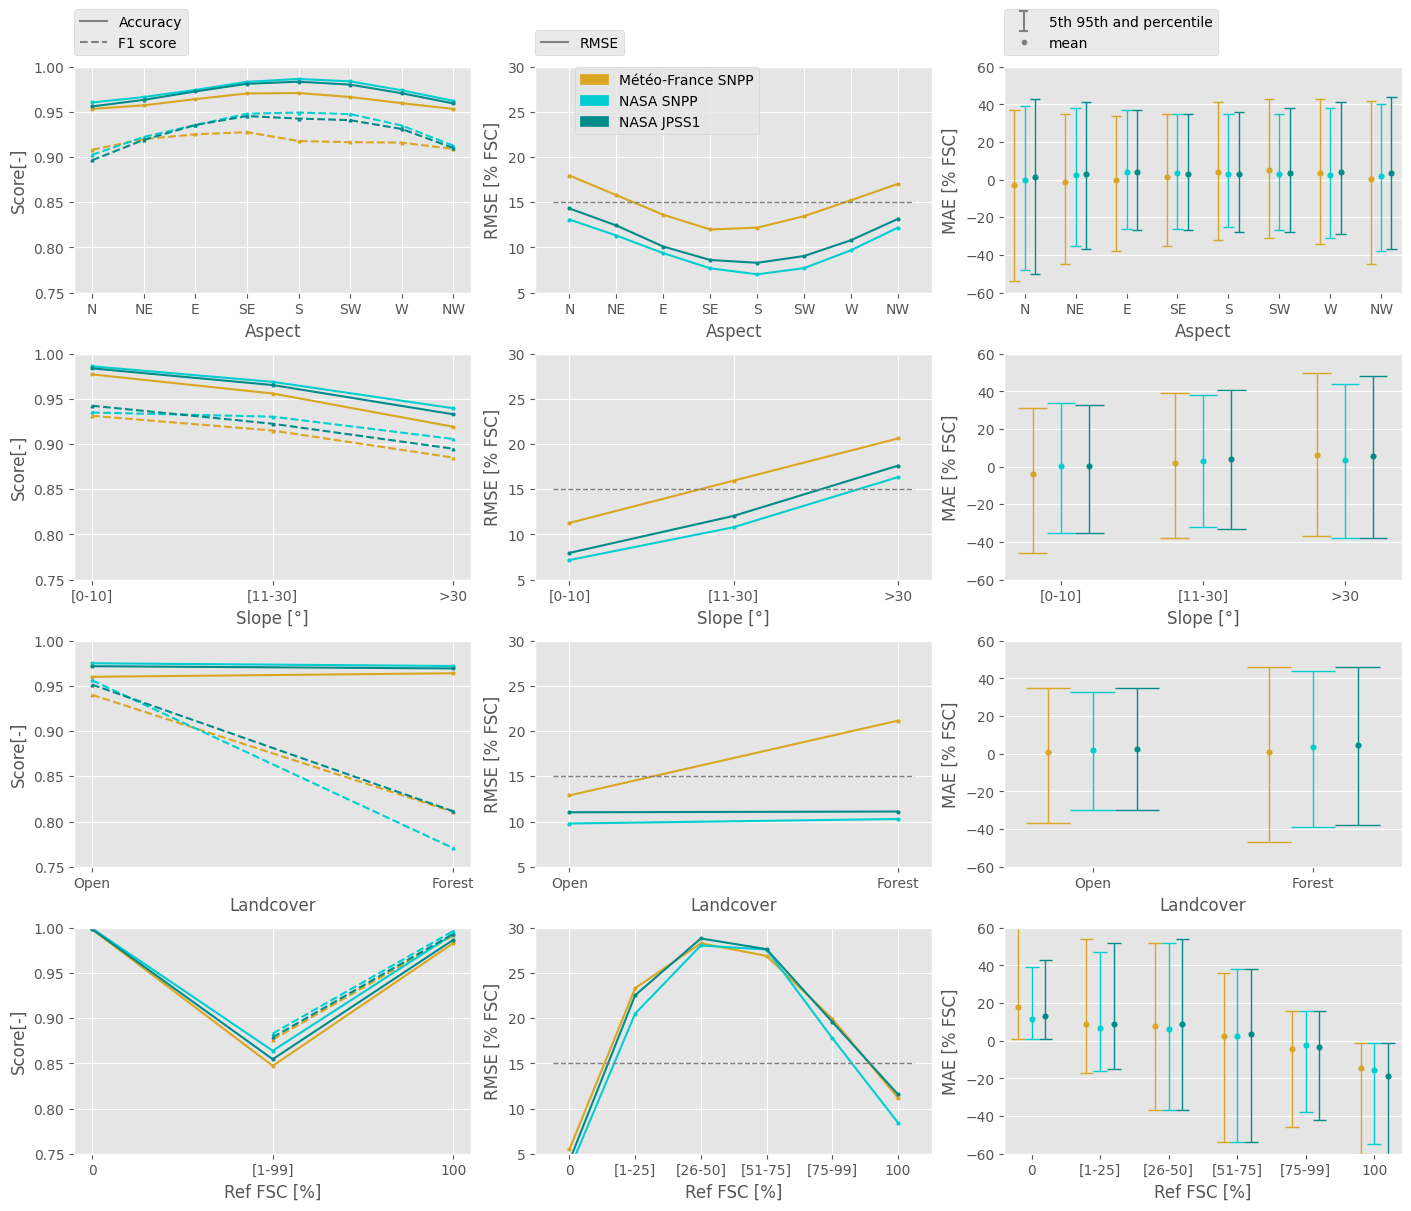

In [ ]:
from typing import List
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from postprocess.error_distribution import histograms_to_biais_rmse, histograms_to_distribution, postprocess_uncertainty_analysis
from postprocess.lps_plots import HandlerPoint, HandlerSpan, compute_skill_scores_for_parameter, plot_custom_spans, plot_synthesis, smooth_data_np_convolve
from products.plot_settings import PRODUCT_PLOT_COLORS, PRODUCT_PLOT_NAMES
import matplotlib.patches as mpatches





params = ["Aspect", "Slope [°]", "Landcover","Ref FSC [%]"] 
plt.style.use('ggplot')
plot_synthesis(metrics_dict_conf, metrics_dict_unc, params_list=params)


In [ ]:
from typing import Dict

import numpy as np

from products.plot_settings import NASA_L3_MULTIPLATFORM_VAR_NAME, PRODUCT_PLOT_COLORS, NASA_L3_JPSS1_VAR_NAME, NASA_L3_SNPP_VAR_NAME
import xarray as xr
from matplotlib import pyplot as plt
from postprocess.error_distribution import histograms_to_biais_rmse

analysis_type = "completeness"
analysis_folder = (
    "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_6_lps/analyses/"
)
analyses_dict_completeness = {
    # MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME: xr.open_dataset(
    #     f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_meteofrance_no_forest_red_band_screen.nc",
    #     decode_cf=True,
    # ),

    NASA_L3_SNPP_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_snpp.nc", decode_cf=True
    ),
    NASA_L3_JPSS1_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_jpss1.nc",
        decode_cf=True,
    ),
    NASA_L3_MULTIPLATFORM_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_multiplatform.nc",
        decode_cf=True,
    ),

}

metrics_dict_completeness = {k:v.sel(time=slice('2023-11', '2024-06')) for k,v in analyses_dict_completeness.items()}

analysis_type = "uncertainty"

analyses_dict_uncertainty = {
    MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_meteofrance_no_forest_red_band_screen_vs_s2_theia.nc",
        decode_cf=True,
    ),
    NASA_L3_SNPP_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_snpp_vs_s2_theia.nc", decode_cf=True
    ),
    NASA_L3_JPSS1_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_jpss1_vs_s2_theia.nc",
        decode_cf=True,
    ),
    NASA_L3_MULTIPLATFORM_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_multiplatform_vs_s2_theia.nc",
        decode_cf=True,
    ),
}

metrics_dict_unc = {k:v.resample({"time": "1ME"}).sum(dim="time") for k,v in analyses_dict_uncertainty.items()}
metrics_dict_unc = {k:v.groupby("time").map(histograms_to_biais_rmse) for k,v in metrics_dict_unc.items()}

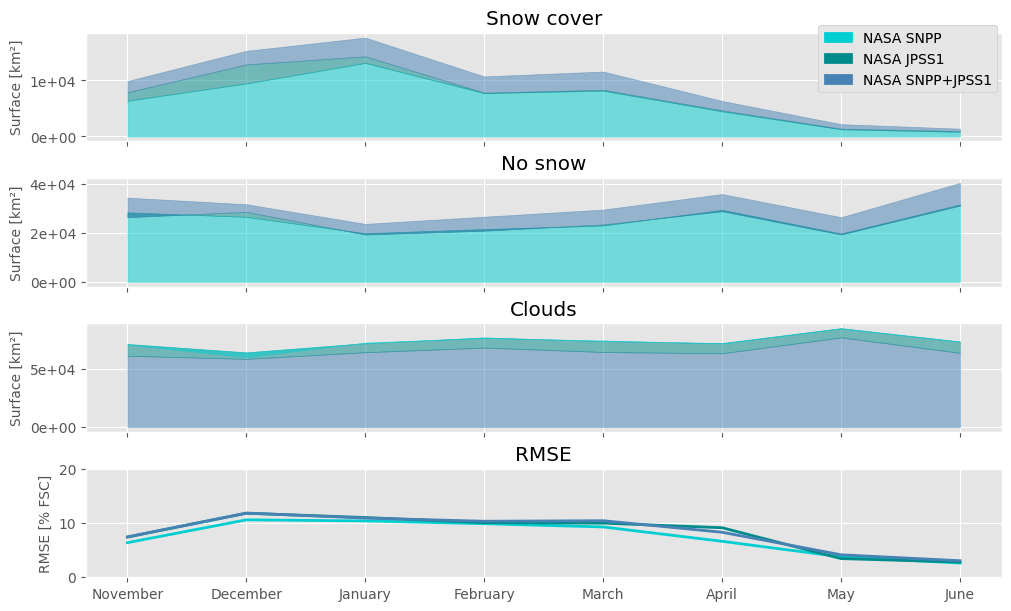

In [ ]:
from postprocess.lps_plots import annual_area_fancy_plot

annual_area_fancy_plot(metrics_dict_completeness=metrics_dict_completeness,metrics_dict_uncertainty=metrics_dict_unc)

meteofrance_synopsis forest
nasa_l3_snpp forest
nasa_l3_jpss1 forest


/tmp/ipykernel_34532/3346203390.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


meteofrance_synopsis forest
nasa_l3_snpp forest
nasa_l3_jpss1 forest


/tmp/ipykernel_34532/3346203390.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


meteofrance_synopsis forest
nasa_l3_snpp forest
nasa_l3_jpss1 forest


/tmp/ipykernel_34532/3346203390.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


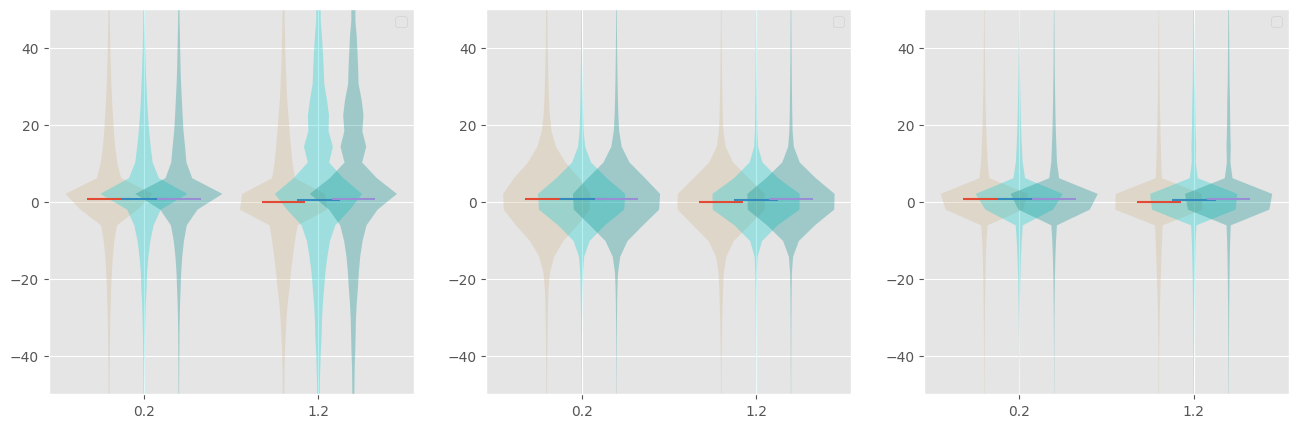

In [ ]:

def raw_error_violinplots(metrics_dict: Dict[str, xr.Dataset], analysis_var: str, ax: Axes, **violinplots_kwargs):
    ticks = np.arange(len(list(metrics_dict.values())[0].coords[analysis_var].values))
    for product_name in metrics_dict:
        error_distributions = []


        prod_selected_metrics = metrics_dict[product_name].groupby((analysis_var, 'time')).map()
        error_distributions.append(histograms_to_distribution(prod_selected_metrics))

        product_boxplot = ax.violinplot(
            error_distributions,
            positions=ticks,
            **violinplots_kwargs
            # showextrema=False,
            # points=100,
            # showmeans=True,
            # showmedians=True,
            # quantiles=[[0.1,0.9],[0.1,0.9]]

            # widths=0.2,
            # showfliers=False,
            # patch_artist=True,
            # label=PRODUCT_PLOT_NAMES[product_name],
        )
        for patch in product_boxplot["bodies"]:
            patch.set_facecolor(PRODUCT_PLOT_COLORS[product_name])
        ticks = ticks + 0.2

        print(product_name, value)

    ticks = np.arange(len(list(metrics_dict.values())[0].coords[analysis_var].values))
    ax.set_xticks(ticks + (len(metrics_dict) - 1) * 0.2 / 2)
    ax.grid(True, axis="y")
    ax.legend()

figs, axs = plt.subplots(1,3, figsize=(16, 5))
[ax.set_ylim(-50,50) for ax in axs]
raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[0],showextrema=False,points=50,showmeans=True )
raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[1],showextrema=False,points=50,bw_method=0.5,showmeans=True )
raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[2],showextrema=False,points=50,bw_method=0.1,showmeans=True )
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[1],showextrema=False,points=100,showmeans=True )
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[2],showextrema=False,points=200,showmeans=True )

/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimensi

meteofrance_synopsis NW


/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimensi

nasa_l3_snpp NW


/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimensi

nasa_l3_jpss1 NW


/tmp/ipykernel_27950/3067715573.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


(None,)

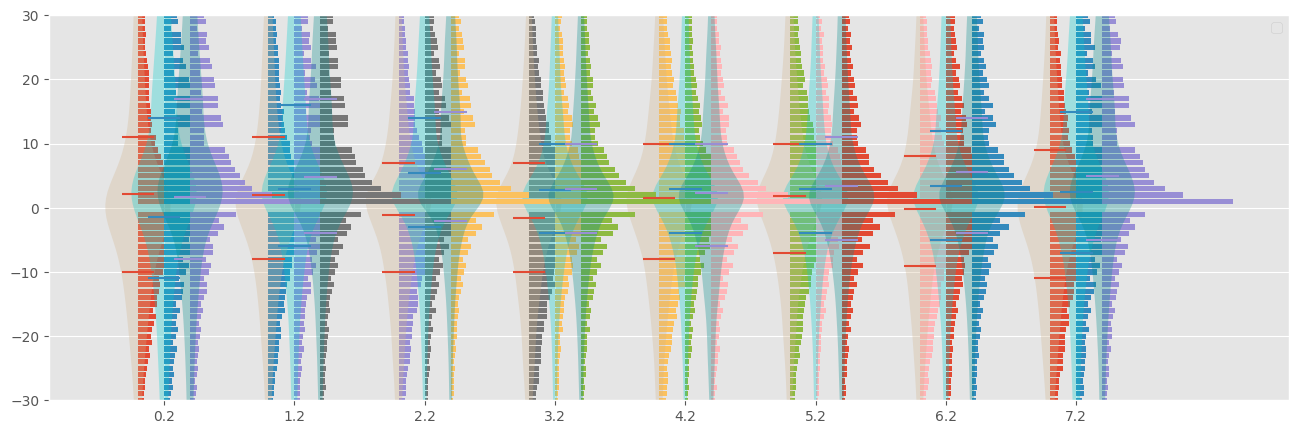

In [143]:
from postprocess.error_distribution import histograms_to_biais_rmse, histograms_to_distribution
from products.plot_settings import PRODUCT_PLOT_COLORS
def raw_error_violinplots(metrics_dict: Dict[str, xr.Dataset], analysis_var: str, ax: Axes, **violinplots_kwargs):
    ticks = np.arange(len(list(metrics_dict.values())[0].coords[analysis_var].values))
    for product_name in metrics_dict:
        error_distributions = []

        for i,value in enumerate(metrics_dict[product_name].coords[analysis_var].values):
            prod_selected_metrics = metrics_dict[product_name].sel({analysis_var: value}).drop_sel(biais_bins=[0])
            error_distributions.append(histograms_to_distribution(prod_selected_metrics))
            red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
            ax.barh(red.biais_bins,width=red.n_occurrences/red.n_occurrences.max(),left=ticks[i])

        product_boxplot = ax.violinplot(
            error_distributions,
            positions=ticks,
            **violinplots_kwargs,
            # showextrema=False,
            # points=100,
            # showmeans=True,
            # showmedians=True,
            quantiles=[[0.25,0.75],[0.25,0.75],[0.25,0.75],[0.25,0.75],[0.25,0.75],[0.25,0.75],[0.25,0.75],[0.25,0.75]]

            # widths=0.2,
            # showfliers=False,
            # patch_artist=True,
            # label=PRODUCT_PLOT_NAMES[product_name],
        )


        for patch in product_boxplot["bodies"]:
            patch.set_facecolor(PRODUCT_PLOT_COLORS[product_name])
        ticks = ticks + 0.2

        print(product_name, value)

    ticks = np.arange(len(list(metrics_dict.values())[0].coords[analysis_var].values))
    ax.set_xticks(ticks + (len(metrics_dict) - 1) * 0.2 / 2)
    ax.grid(True, axis="y")
    ax.legend()

figs, axs = plt.subplots(1,1, figsize=(16, 5))
# figs.style.use('ggplot')
# [axs[0].set_ylim(-50,50) for ax in axs]
axs.set_ylim(-30,30)
raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var='aspect_bins', ax=axs,showextrema=False,points=200,showmeans=True),#quantiles=[[0.1,0.9],[0.1,0.9],[0.1,0.9],[0.1,0.9],[0.1,0.9]])
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[1],showextrema=False,points=200,bw_method=0.5,showmeans=True )
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[2],showextrema=False,points=200,bw_method=0.1,showmeans=True )
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[1],showextrema=False,points=100,showmeans=True )
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[2],showextrema=False,points=200,showmeans=True )

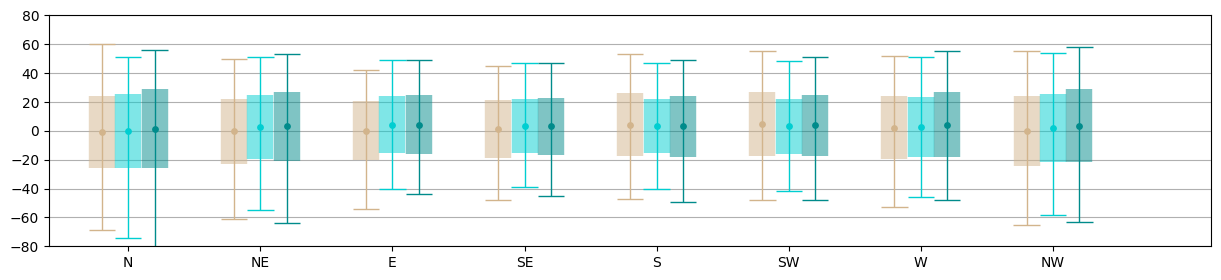

In [ ]:
from typing import Any
import numpy as np
from postprocess.error_distribution import histograms_to_biais_rmse, histograms_to_distribution
from products.plot_settings import PRODUCT_PLOT_COLORS
def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")
# red = metrics_dict_unc['meteofrance_synopsis'].sel(aspect_bins='S')

def linewidth_from_data_units(linewidth, axis, reference='y'):
    """
    Convert a linewidth in data units to linewidth in points.

    Parameters
    ----------
    linewidth: float
        Linewidth in data units of the respective reference-axis
    axis: matplotlib axis
        The axis which is used to extract the relevant transformation
        data (data limits and size must not change afterwards)
    reference: string
        The axis that is taken as a reference for the data width.
        Possible values: 'x' and 'y'. Defaults to 'y'.

    Returns
    -------
    linewidth: float
        Linewidth in points
    """
    fig = axis.get_figure()
    if reference == 'x':
        length = fig.bbox_inches.width * axis.get_position().width
        value_range = np.diff(axis.get_xlim())
    elif reference == 'y':
        length = fig.bbox_inches.height * axis.get_position().height
        value_range = np.diff(axis.get_ylim())
    # Convert length to points
    length *= 72
    # Scale linewidth to value range
    return linewidth * (length / value_range)




def plot_custom_violin(metrics_dict: Dict[str, xr.Dataset],analysis_var: str,  ax :plt.Axes):
    
    x_positions = np.arange(len(list(metrics_dict.values())[0].coords[analysis_var].values))
    x_positions = x_positions/len(x_positions)
    ax.set_ylim(-80,80)
    ax.set_xlim(-0.05,1.05)
    for product_name, metrics_dataset in metrics_dict.items():
        
        color = PRODUCT_PLOT_COLORS[product_name]
        analysis_coords = metrics_dict[product_name].coords[analysis_var].values
        box_width_data = 0.2/len(x_positions)
        fig = ax.get_figure()
        w = fig.bbox_inches.width* ax.get_position().width
        value_range = np.diff(ax.get_xlim())
        box_width_points = box_width_data * (72*w/value_range)
        # print(linewidth_from_data_units(box_width_data,ax,'y'))
        for idx, value in enumerate(analysis_coords):
            x_pos = x_positions[idx]
            product_analysis_var_dataset=  metrics_dataset.sel({analysis_var: value}).drop_sel(biais_bins=0)
            reduced =product_analysis_var_dataset.groupby('biais_bins').sum(list(product_analysis_var_dataset.sizes.keys()))
            smooth = smooth_data_np_convolve(reduced.data_vars['n_occurrences'], 1)
            smooth = smooth/smooth.max() 


            biais_rmse = histograms_to_biais_rmse(reduced)
            distr = histograms_to_distribution(reduced)
            ax.scatter(x_pos, biais_rmse.data_vars['biais'], marker='o', color=color, s=15,zorder=3)

            whiskers_min=np.quantile(distr,0.02)
            whiskers_max=np.quantile(distr,0.98)
            ax.vlines(x_pos, whiskers_min, whiskers_max, color=color, linestyle='-', lw=1)
            ax.vlines(x_pos, biais_rmse.biais-biais_rmse.rmse, biais_rmse.biais+biais_rmse.rmse, color=color, linestyle='-', lw=box_width_points,alpha=0.5)

            ax.hlines(whiskers_min, x_pos-box_width_data/2, x_pos+box_width_data/2, color=color, lw=1)
            ax.hlines(whiskers_max, x_pos-box_width_data/2,x_pos+box_width_data/2, color=color, lw=1)
        x_positions = x_positions+box_width_data
    
    ax.set_xticks(x_positions - box_width_data*((len(metrics_dict)+1)//2), labels=analysis_coords)
    # ax.set_xticklabels()


fig, ax = plt.subplots(figsize=(15,3))


metrics_dict_unc_new = {k: v.sel(ref_bins=slice(None, 101)) for k,v in metrics_dict_unc.items()}
ax.grid(axis='y')
plot_custom_violin(metrics_dict=metrics_dict_unc_new, analysis_var='aspect_bins',ax=ax)

# ticks = []
# selection = metrics_dict_unc['meteofrance_synopsis'].sel(ref_bins=slice(None, 101))
# for i, b in enumerate(selection.ref_bins):
#     plot_custom_violin(ds = selection.sel(ref_bins=b), ax=ax,x_pos=i*3)
#     ticks.append(i*3)
# ax.set_xticks(ticks)
# ax.set_xticklabels(selection.ref_bins.values)



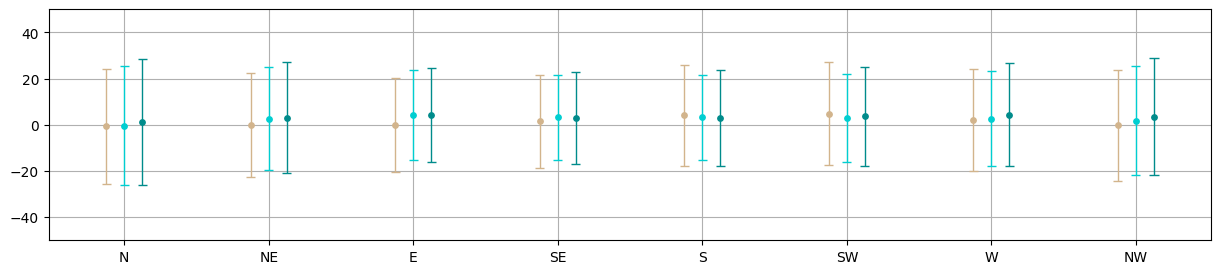

In [6]:
from typing import Any
import numpy as np
from postprocess.error_distribution import histograms_to_biais_rmse, histograms_to_distribution
from products.plot_settings import PRODUCT_PLOT_COLORS
def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")
# red = metrics_dict_unc['meteofrance_synopsis'].sel(aspect_bins='S')

def plot_custom_violin(metrics_dict: Dict[str, xr.Dataset],analysis_var: str,  ax :plt.Axes):
    x_positions = np.arange(8*len(list(metrics_dict.values())[0].coords[analysis_var].values),step=8)
    for product_name, metrics_dataset in metrics_dict.items():
        
        color = PRODUCT_PLOT_COLORS[product_name]
        analysis_coords = metrics_dict[product_name].coords[analysis_var].values
        for idx, value in enumerate(analysis_coords):
            x_pos = x_positions[idx]
            product_analysis_var_dataset=  metrics_dataset.sel({analysis_var: value}).drop_sel(biais_bins=0)
            reduced =product_analysis_var_dataset.groupby('biais_bins').sum(list(product_analysis_var_dataset.sizes.keys()))
            smooth = smooth_data_np_convolve(reduced.data_vars['n_occurrences'], 1)
            smooth = smooth/smooth.max() 

            # ax.fill_betweenx(reduced.coords['biais_bins'],x_pos,x_pos+smooth,color=color, alpha=0.25)
            # ax.plot(x_pos+smooth, reduced.coords['biais_bins'],color=color,lw=0.5)
            # ax.fill_betweenx( reduced.coords['biais_bins'],x_pos, x_pos-smooth,color=color, alpha=0.25)
            # ax.plot(x_pos-smooth, reduced.coords['biais_bins'],color=color,lw=0.5)

            biais_rmse = histograms_to_biais_rmse(reduced)
            distr = histograms_to_distribution(reduced)
            # ax.vlines(x_pos, np.quantile(distr,0.05), np.quantile(distr,0.95), color=color, linestyle='-',alpha=0.5, lw=5)
            ax.scatter(x_pos, biais_rmse.data_vars['biais'], marker='o', color=color, s=15,zorder=3)

            # whiskers_min=reduced.where(reduced.data_vars['n_occurrences']>0,drop=True).coords['biais_bins'].min()
            # whiskers_max=reduced.where(reduced.data_vars['n_occurrences']>0,drop=True).coords['biais_bins'].max()
            whiskers_min=biais_rmse.biais - biais_rmse.rmse
            whiskers_max=biais_rmse.biais + biais_rmse.rmse
            ax.vlines(x_pos, whiskers_min, whiskers_max, color=color, linestyle='-', lw=1)
            ax.hlines(whiskers_min, x_pos-0.25, x_pos+0.25, color=color, lw=1)
            ax.hlines(whiskers_max, x_pos-0.25,x_pos+ 0.25, color=color, lw=1)
        x_positions = x_positions+1
    ax.set_ylim(-50,50)
    ax.set_xticks(x_positions - 1*((len(metrics_dict)+1)//2))
    ax.set_xticklabels(analysis_coords)


fig, ax = plt.subplots(figsize=(15,3))


metrics_dict_unc_new = {k: v.sel(ref_bins=slice(None, 101)) for k,v in metrics_dict_unc.items()}
plot_custom_violin(metrics_dict=metrics_dict_unc_new, analysis_var='aspect_bins',ax=ax)
ax.grid('y')
# ticks = []
# selection = metrics_dict_unc['meteofrance_synopsis'].sel(ref_bins=slice(None, 101))
# for i, b in enumerate(selection.ref_bins):
#     plot_custom_violin(ds = selection.sel(ref_bins=b), ax=ax,x_pos=i*3)
#     ticks.append(i*3)
# ax.set_xticks(ticks)
# ax.set_xticklabels(selection.ref_bins.values)

